In [1]:
import numpy as np
import matplotlib.pyplot as plt
import celluloid
import sklearn.datasets as ds

In [2]:
plt.style.use("ggplot")

In [3]:
X, y = ds.make_moons(16**2, 2, noise=0.2)
n_examples, n_features = X.shape
n_examples, n_features

(256, 2)

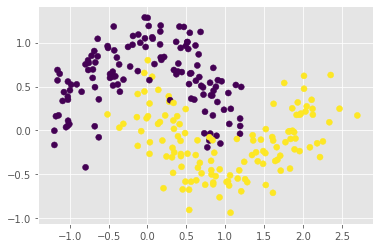

In [4]:
plt.scatter(X[:,0],X[:,1],c=y)

In [62]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-(Z)))
def sigmoid_forward(Z):
    return sigmoid(Z)
def sigmoid_backward(Z):
    return sigmoid(Z) * (1-sigmoid(Z))
    
def relu_forward(Z):
    Z[Z<0] = 0
    return Z
def relu_backward(Z):
    return 0<Z

def cost(y, y_pred):
    assert y.shape == y_pred.shape, (y.shape, y_pred.shape)
    return np.mean(-y*np.log(y_pred) - (1-y)*np.log(1-y_pred))
def cost_prime(y, y_pred):
    return y_pred - y

In [56]:
def intialize_weights(hidden_layer_dimensions):
    """initialize the weights and biases, as well as specify
    the activation function -- ReLu for hidden layer, sigmoid
    for the output layer"""
    weights, biases, activation_functions = [], [], []
    for i in range(len(hidden_layer_dimensions)-1):
        n_units_previous_layer = hidden_layer_dimensions[i]
        n_units_current_layer  = hidden_layer_dimensions[i+1]
        weights.append(np.random.uniform(-0.1, 0.1, (n_units_previous_layer, n_units_current_layer)))
        biases.append(np.zeros((1, n_units_current_layer)))
        activation_functions.append("relu" if i < len(hidden_layer_dimensions)-2 else "sigmoid")
    return weights, biases, activations

weights, biases, activation_functions = list(intialize_weights([2,3,2,1]))
assert [w.shape for w in weights] == [(2, 3), (3, 2), (2, 1)]
assert [b.shape for b in biases] == [(1, 3), (1, 2), (1, 1)]
assert activations == ['relu', 'relu', 'sigmoid']

In [57]:
weights, biases, activation_functions

([array([[-0.08902561,  0.00991479,  0.0568923 ],
         [ 0.09087216, -0.08217068, -0.03741881]]),
  array([[ 0.02791691, -0.03719846],
         [-0.03956323,  0.04902233],
         [ 0.08326826, -0.08829223]]),
  array([[ 6.26489157e-05],
         [-5.51931170e-02]])],
 [array([[0., 0., 0.]]), array([[0., 0.]]), array([[0.]])],
 ['relu', 'relu', 'sigmoid'])

In [61]:
def forward_prop(X, weights, biases, activation_functions):
    preactivations = []
    activations    = []
    for weight, bias, activation_function in zip(weights, biases, activation_functions):
        prev_layer_activation = (X if len(activations) == 0 else activations[-1])
        preactivation = prev_layer_activation @ weight + bias
        if activation_function == "relu":
            activation = relu_forward(preactivation)
        elif activation_function == "sigmoid":
            activation = sigmoid_forward(preactivation)
        preactivations.append(preactivation)
        activations.append(activation)
    return preactivations, activations

preactivations, activations = forward_prop(X, weights, biases, activation_functions)

In [64]:
"""def calculate_gradients(A0, A1, Z0, Z1, W0, W1, b0, b1, Y):
    assert A1.shape == Y.shape
    # hidden layer 1
    dZ1 = (A1 - Y)
    assert dZ1.shape == Z1.shape
    dW1 = (A0.T@dZ1) / n_examples
    assert dW1.shape == W1.shape, (dW1.shape, W1.shape)
    db1 = np.mean(dZ1, axis=0, keepdims=True)
    assert db1.shape == b1.shape, (db1.shape, b1.shape)
    # hidden layer 0
    dZ0 = np.multiply(W1@dZ1.T, relu_backward(Z0).T).T
    assert dZ0.shape == Z0.shape
    dW0 = (dZ0.T@X) / n_examples
    dW0 = dW0.T # TODO: fix the shape here
    assert dW0.shape == W0.shape, (dW0.shape, W0.shape)
    db0 = np.mean(dZ0, axis=0, keepdims=True)
    assert db0.shape == b0.shape, (db0.shape, b0.shape)
    
    return dW0, dW1, db0, db1"""

def calculate_gradients():
    pass